Name: Pokemon Images Dataset

DATASET: https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset/data

# **Модуль 3**

### Подключение библиотек

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid,save_image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, ConcatDataset
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Предварительная обработка данных

In [ ]:
# Гиперпараметры
batch_size = 8 # Количество изображений в каждом батче
image_size = 64 # Размер изображения после изменения размера
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Средние значения и стандартные отклонения для нормализации

data_dir = r'/content/drive/MyDrive/Нейронные сети/POKEMONS' # Директория с изображениями

# Нормализация датасета
normal_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*normalization_stats)]))
# Дополнение датасета зеркальными изображениями
mirror_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(*normalization_stats)]))
# Дополнение датасета изменениями цвета
color_jitter_dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.ToTensor(),
    transforms.Normalize(*normalization_stats)]))

In [ ]:
# Создание (DataLoader) для объединенного датасета (Объединение трех датасетов в один с помощью ConcatDataset)
data_loader = DataLoader(dataset=ConcatDataset([normal_dataset,mirror_dataset,color_jitter_dataset]), batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=False)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


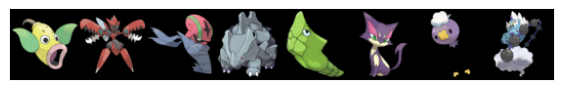

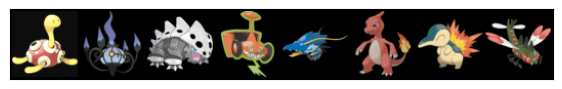

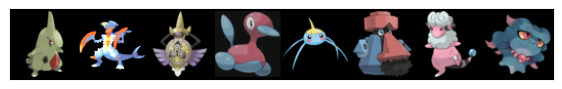

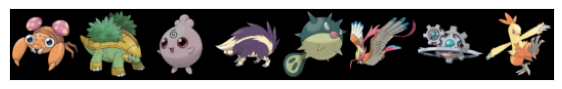

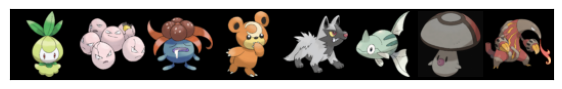

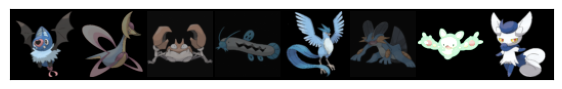

In [ ]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=16).permute(1, 2, 0))

def show_batches(dataloader, n_batches=5, nmax=64):
    batch_count = 0
    for images, _ in dataloader:
        show_images(images, nmax)
        batch_count += 1

        if batch_count >= n_batches:
            break

# Визуализация нескольких батчей изображений
show_batches(data_loader, n_batches=6, nmax=64)
plt.show()

### 1 Модель

In [ ]:
seed_size = 16 # Размер вектора случайного шума (seed) на входе генератора

generator = nn.Sequential(
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False), # Входной слой: принимает входной вектор размером seed_size x 1 x 1
    nn.BatchNorm2d(128),  # Нормализация данных по мини-партиям для стабилизации обучения (значения выходных данных слоя приводятся к определенным среднему значению и стандартному отклонению)
    nn.ReLU(True),  # Функция активации ReLU
    # Выходной размер: 128 x 4 x 4
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False), # Транспонированная свертка для увеличения размера изображения
    nn.BatchNorm2d(128), # Нормализация данных по мини-партиям
    nn.ReLU(True),  # Функция активации ReLU
    # Выходной размер: 128 x 8 x 8
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Выходной размер: 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Выходной размер: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False), # Транспонированная свертка для увеличения размера изображения до исходных размеров
    nn.Tanh() # Применяет функцию активации Tanh для нормализации значений в диапазоне от -1 до 1
    # Выход: 3 x 64 x 64
)
generator.to(device)  # Отправка модели на устройство (CPU)

Sequential(
  (0): ConvTranspose2d(16, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # Входное изображение: 3 x 64 x 64. Свертка с ядром 4x4, шагом 2 и отступом 1
    nn.BatchNorm2d(64), # Нормализация данных по мини-партиям
    nn.LeakyReLU(0.2, inplace=True),  # Функция активации LeakyReLU
    # Выход слоя: 64 x 32 x 32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Выход слоя: 128 x 16 x 16
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Выход слоя: 128 x 8 x 8
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Выход слоя: 128 x 4 x 4
    # Используя размер 4x4, сжимаем каналы в 1 x 1 x 1 для получения выходных данных
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),   # Преобразование трехмерного тензора в одномерный
    nn.Sigmoid()    # Применение функции сигмоиды для бинарной классификации (реальный/фейковый)
)
discriminator.to(device) # Отправка модели на устройство (CPU)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

### 2 Модель

In [ ]:
seed_size = 16 # Размер вектора случайного шума (seed) на входе генератора

generator = nn.Sequential(
    nn.ConvTranspose2d(seed_size, 512, kernel_size=4, padding=0, stride=1, bias=False), # Входной слой: принимает входной вектор размером seed_size x 1 x 1. Применяет транспонированную свертку для увеличения размера изображения.
    nn.BatchNorm2d(512), # Нормализация данных по мини-партиям
    nn.ReLU(True), # Функция активации ReLU
    # Выходной размер: 512 x 4 x 4
    nn.ConvTranspose2d(512, 256, kernel_size=4, padding=1, stride=2, bias=False), # Транспонированная свертка для увеличения размера изображения
    nn.BatchNorm2d(256),  # Нормализация данных по мини-партиям
    nn.ReLU(True),  # Функция активации ReLU
    # Выход: 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Выходной размер: 128 x 16 x 16
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Выходной размер: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),  # Транспонированная свертка для увеличения размера изображения до исходных размеров
    nn.Tanh() # Функцию активации Tanh для нормализации значений в диапазоне от -1 до 1
    # Выход: 3 x 64 x 64
)
generator.to(device)

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # Входной слой. Применяет свертку с ядром 4x4, шагом 2 и отступом 1.
    nn.BatchNorm2d(64), # Нормализация данных по мини-партиям
    nn.LeakyReLU(0.2, inplace=True),  # Функция активации LeakyReLU
    # Выходной размер: 64 x 128 x 128
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # Свертка с ядром 4x4, шагом 2 и отступом 1.
    nn.BatchNorm2d(128),  # Нормализация данных по мини-партиям
    nn.LeakyReLU(0.2, inplace=True),  # Функция активации LeakyReLU
    # Выходной размер: 128 x 64 x 64
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # Выходной размер: 256 x 32 x 32
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # Выходной размер: 512 x 16 x 16
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),  # Свертка с ядром 4x4, шагом 1 и отступом 0.
    nn.Flatten(), # Преобразует трехмерный тензор в одномерный
    nn.Sigmoid()  # Применяет функцию активации сигмоиду для бинарной классификации
)
discriminator.to(device)

### 3 Модель

In [ ]:
seed_size = 100

generator = nn.Sequential(
    nn.ConvTranspose2d(seed_size, 64 * 8, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(64 * 8),
    nn.ReLU(True),
    # Выходной размер: 512 x 4 x 4
    nn.ConvTranspose2d(64 * 8, 64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64 * 4),
    nn.ReLU(True),
    # Выходной размер: 256 x 8 x 8
    nn.ConvTranspose2d(64 * 4, 64 * 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64 * 2),
    nn.ReLU(True),
    # Выходной размер: 128 x 16 x 16
    nn.ConvTranspose2d(64 * 2, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Выходной размер: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False), # Финальный слой: преобразует изображение в 3-канальное изображение (цветное) размером 64 x 64
    nn.Tanh()
    # Выход: 3 x 64 x 64
)
generator.to(device)

In [ ]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False), # Вход: 3 x 64 x 64 (цветное изображение). Применяет свертку с ядром 4x4, шагом 2 и отступом 1.
    nn.LeakyReLU(0.2, inplace=True), # Функция активации LeakyReLU
    # Выходной размер: 64 x 32 x 32
    nn.Conv2d(64, 64 * 2, kernel_size=4, stride=2, padding=1, bias=False),  # Свертка с ядром 4x4, шагом 2 и отступом 1.
    nn.BatchNorm2d(64 * 2), # Нормализация данных по мини-партиям
    nn.LeakyReLU(0.2, inplace=True),  # Функция активации LeakyReLU
    # Выходной размер: 128 x 16 x 16
    nn.Conv2d(64 * 2, 64 * 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64 * 4),
    nn.LeakyReLU(0.2, inplace=True),
    # Выходной размер: 256 x 8 x 8
    nn.Conv2d(64 * 4, 64 * 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64 * 8),
    nn.LeakyReLU(0.2, inplace=True),
    # Выходной размер: 512 x 4 x 4
    nn.Conv2d(64 * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),  # Преобразует трехмерный тензор в одномерный
    nn.Sigmoid()  # Применяет функцию активации сигмоиду для бинарной классификации
)

discriminator.to(device)

### Обучение

In [ ]:
# Тренировка дискриминатора на реальных и поддельных данных
def train_discriminator(real_pokemon, disc_optimizer):
    disc_optimizer.zero_grad()  # Сброс градиентов для оптимизатора

    # Тренировка на реальных изображениях
    real_predictions = discriminator(real_pokemon)
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0 # Целевые значения для реальных изображений (незначительные шумовые метки, чтобы усложнить задачу для дискриминатора)
    real_loss = F.binary_cross_entropy(real_predictions, real_targets) # Потеря по бинарной кросс-энтропии для реальных изображений
    real_score = torch.mean(real_predictions).item() # Оценка того, насколько хорошо дискриминатор классифицирует реальные покемоны (высокий балл - лучше)

    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)  # Создание случайных латентных векторов для генератора (генерации случайных векторов из распределения, обычно нормального (гауссового), который используется в качестве входных данных для генератора). Эти латентные векторы позволяет генератору создавать поддельные изображения или данные.

    fake_pokemon = generator(latent_batch)  # Генерация поддельных изображений покемонов

    gen_predictions = discriminator(fake_pokemon) # Тренировка на текущих попытках генератора обмануть дискриминатор
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9 # Целевые значения для поддельных изображений (незначительные шумовые метки, чтобы усложнить задачу для дискриминатора)
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets) # Потеря по бинарной кросс-энтропии для поддельных изображений. Она оценивает его эффективность и помогает улучшить его способности различать
    gen_score = torch.mean(gen_predictions).item() # Оценка того, насколько хорошо дискриминатор классифицирует поддельных покемонов (более низкий балл - лучше)

    # Обновление весов дискриминатора
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    # Возвращение итоговой потери и оценок
    return total_loss.item(), real_score, gen_score

In [ ]:
def train_generator(gen_optimizer):
    gen_optimizer.zero_grad() # Сброс градиентов генератора

    # Создание некоторых поддельных покемонов
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch) # Используем генератор для генерации поддельных изображений

    # Проверка против дискриминатора
    disc_predictions = discriminator(fake_pokemon) # Дискриминатор оценивает, насколько поддельные кажутся настоящими
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device) # Целевые значения для обучения генератора: хотим, чтобы дискриминатор считал эти изображения настоящими.
    loss = F.binary_cross_entropy(disc_predictions, targets) # Расчет потери генератора: разница между оценками дискриминатора и целевыми значениями

    # Обновление генератора
    loss.backward()
    gen_optimizer.step()

    # Вернуть потерю генератора
    return loss.item()

In [ ]:
import os
from torchvision.utils import save_image

RESULTS_DIR = '/content/drive/MyDrive/Нейронные сети/RESULTONE'
os.makedirs(RESULTS_DIR, exist_ok=True)

def save_results(index, latent_batch, show=True):
    fake_pokemon = generator(latent_batch)  # Генерация поддельных покемонов
    fake_file = "result-image-{0:0=4d}.png".format(index) # Создание имени файла для сохранения
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)  # Сохранение изображения
    print("Результат сохранен!")

    if show:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
# Функция обучения GAN

# Статический батч с фиксированным латентным пространством для генерации  (служит для стабильности, демонстрации прогресса модели и удобства сравнения результатов)
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    torch.cuda.empty_cache()  # Освобождаем кэш GPU для экономии памяти
    # Отслеживаем потери и оценки
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    # Создание оптимизаторов
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    # Запускаем цикл по эпохам
    for epoch in range(epochs):
        # Проходим через каждое изображение
        for real_img, _ in tqdm(data_loader):
            real_img = real_img.to(device)
            # Обучаем дискриминатор
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)
            # Обучаем генератор
            gen_loss = train_generator(gen_optimizer)
        # Сбор результатов
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        # Вывод потери и оценки
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        # Сохраняем изображения и показываем прогресс
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
    # Возврат статистики
    return disc_losses, disc_scores, gen_losses, gen_scores

In [ ]:
learning_rate = 3e-4  # скорость обучения
epochs = 50 # количество эпох обучения

In [ ]:
# Обучение модели GAN
history = train(epochs, learning_rate)

  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [1/50], gen_loss: 1.2965, disc_loss: 3.8744, real_score: 0.9781, gen_score: 0.8362
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [2/50], gen_loss: 4.2995, disc_loss: 0.6625, real_score: 0.0600, gen_score: 0.7379
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [3/50], gen_loss: 1.5802, disc_loss: 1.2638, real_score: 0.2031, gen_score: 0.3987
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [4/50], gen_loss: 1.4695, disc_loss: 1.7982, real_score: 0.7830, gen_score: 0.7646
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [5/50], gen_loss: 1.6994, disc_loss: 2.9688, real_score: 0.9325, gen_score: 0.6406
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [6/50], gen_loss: 1.2062, disc_loss: 0.7720, real_score: 0.3552, gen_score: 0.7729
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [7/50], gen_loss: 2.0638, disc_loss: 1.0068, real_score: 0.5383, gen_score: 0.8856
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [8/50], gen_loss: 1.5765, disc_loss: 0.8390, real_score: 0.4136, gen_score: 0.7952
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [9/50], gen_loss: 0.9902, disc_loss: 1.2797, real_score: 0.6612, gen_score: 0.8746
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [10/50], gen_loss: 3.9745, disc_loss: 0.4247, real_score: 0.0532, gen_score: 0.8877
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [11/50], gen_loss: 4.0805, disc_loss: 0.9345, real_score: 0.0564, gen_score: 0.4966
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [12/50], gen_loss: 2.6308, disc_loss: 0.5507, real_score: 0.2277, gen_score: 0.8999
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [13/50], gen_loss: 1.0859, disc_loss: 1.4401, real_score: 0.6468, gen_score: 0.7620
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [14/50], gen_loss: 2.6769, disc_loss: 0.8367, real_score: 0.0043, gen_score: 0.6837
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [15/50], gen_loss: 2.1289, disc_loss: 1.0402, real_score: 0.0067, gen_score: 0.6317
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [16/50], gen_loss: 1.9498, disc_loss: 0.6238, real_score: 0.1146, gen_score: 0.7870
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [17/50], gen_loss: 4.2308, disc_loss: 0.6279, real_score: 0.0692, gen_score: 0.7274
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [18/50], gen_loss: 0.4229, disc_loss: 2.3808, real_score: 0.8875, gen_score: 0.7451
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [19/50], gen_loss: 1.2291, disc_loss: 1.3496, real_score: 0.6263, gen_score: 0.7208
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [20/50], gen_loss: 0.8795, disc_loss: 1.2935, real_score: 0.6347, gen_score: 0.7895
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [21/50], gen_loss: 2.8928, disc_loss: 0.8901, real_score: 0.0716, gen_score: 0.5624
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [22/50], gen_loss: 2.1759, disc_loss: 0.7033, real_score: 0.2851, gen_score: 0.8802
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [23/50], gen_loss: 4.3868, disc_loss: 0.3164, real_score: 0.0331, gen_score: 0.9475
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [24/50], gen_loss: 1.7043, disc_loss: 0.5429, real_score: 0.2549, gen_score: 0.8936
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [25/50], gen_loss: 1.8897, disc_loss: 0.7837, real_score: 0.3536, gen_score: 0.8371
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [26/50], gen_loss: 3.6683, disc_loss: 0.7793, real_score: 0.1409, gen_score: 0.6474
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [27/50], gen_loss: 3.4219, disc_loss: 0.3311, real_score: 0.0212, gen_score: 0.8586
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [28/50], gen_loss: 2.7002, disc_loss: 1.9093, real_score: 0.8304, gen_score: 0.9915
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [29/50], gen_loss: 1.0546, disc_loss: 0.5032, real_score: 0.1316, gen_score: 0.8501
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [30/50], gen_loss: 3.4263, disc_loss: 1.2082, real_score: 0.0218, gen_score: 0.4539
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [31/50], gen_loss: 2.5147, disc_loss: 0.7448, real_score: 0.0210, gen_score: 0.7229
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [32/50], gen_loss: 0.7346, disc_loss: 1.0641, real_score: 0.5301, gen_score: 0.8228
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [33/50], gen_loss: 0.9820, disc_loss: 1.6726, real_score: 0.7640, gen_score: 0.8565
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [34/50], gen_loss: 3.4564, disc_loss: 0.5520, real_score: 0.1103, gen_score: 0.9527
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [35/50], gen_loss: 2.5204, disc_loss: 0.5050, real_score: 0.1201, gen_score: 0.9254
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [36/50], gen_loss: 2.1882, disc_loss: 1.2125, real_score: 0.6090, gen_score: 0.9742
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [37/50], gen_loss: 4.0276, disc_loss: 0.5383, real_score: 0.0259, gen_score: 0.8221
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [38/50], gen_loss: 4.3782, disc_loss: 0.3840, real_score: 0.0479, gen_score: 0.9529
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [39/50], gen_loss: 2.7525, disc_loss: 0.5765, real_score: 0.1613, gen_score: 0.8765
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [40/50], gen_loss: 2.7335, disc_loss: 0.3822, real_score: 0.0038, gen_score: 0.8838
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [41/50], gen_loss: 1.0737, disc_loss: 1.4728, real_score: 0.6697, gen_score: 0.7440
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [42/50], gen_loss: 2.4694, disc_loss: 0.6892, real_score: 0.1110, gen_score: 0.6629
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [43/50], gen_loss: 3.3860, disc_loss: 0.5219, real_score: 0.1163, gen_score: 0.9494
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [44/50], gen_loss: 1.0139, disc_loss: 2.2887, real_score: 0.8868, gen_score: 0.9606
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [45/50], gen_loss: 1.3698, disc_loss: 1.6743, real_score: 0.7839, gen_score: 0.8943
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [46/50], gen_loss: 2.7473, disc_loss: 0.6470, real_score: 0.0595, gen_score: 0.7549
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [47/50], gen_loss: 4.5591, disc_loss: 0.3448, real_score: 0.0260, gen_score: 0.8730
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [48/50], gen_loss: 3.7889, disc_loss: 0.8877, real_score: 0.0119, gen_score: 0.6161
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [49/50], gen_loss: 2.3309, disc_loss: 0.7011, real_score: 0.2028, gen_score: 0.7476
Результат сохранен!


  0%|          | 0/308 [00:00<?, ?it/s]

Epoch [50/50], gen_loss: 2.5968, disc_loss: 0.4477, real_score: 0.1058, gen_score: 0.9069
Результат сохранен!


In [ ]:
disc_losses, disc_scores, gen_losses, gen_scores = history

### Визуализация результатов

### Результаты 1й модели

### Промежуточные результаты 1й модели

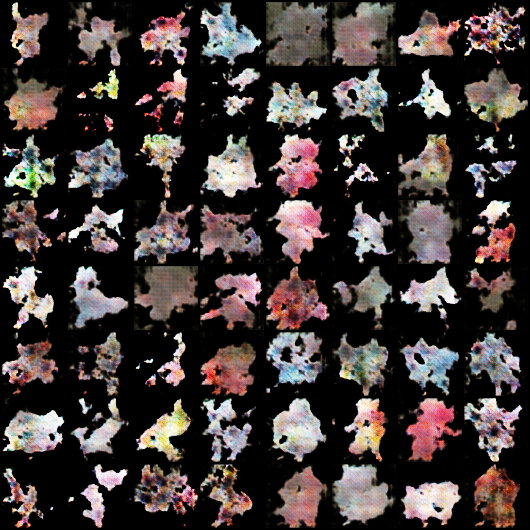

In [ ]:
from IPython.display import Image
Image('/content/drive/MyDrive/Нейронные сети/RESULTONE/result-image-0010.png')

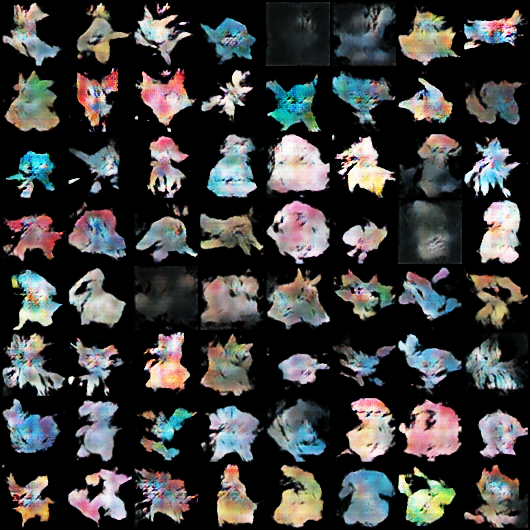

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTONE/result-image-0025.png')

### Итоговый результат 1й модели

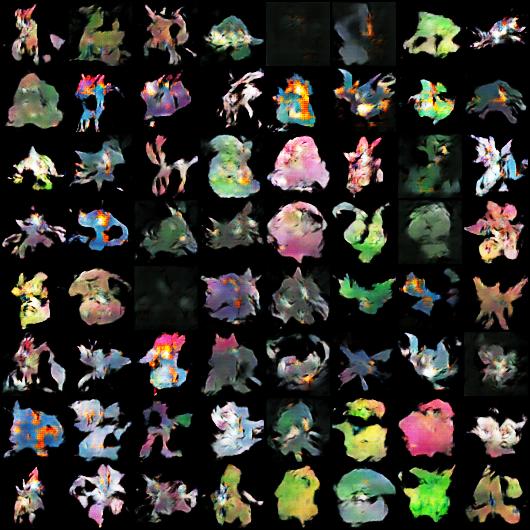

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTONE/result-image-0047.png')

### Результаты 2й модели

### Промежуточные результаты 2й модели

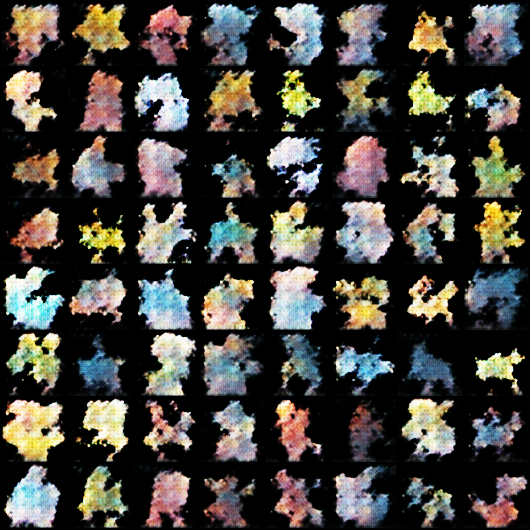

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTWO/result-image-0006.png')

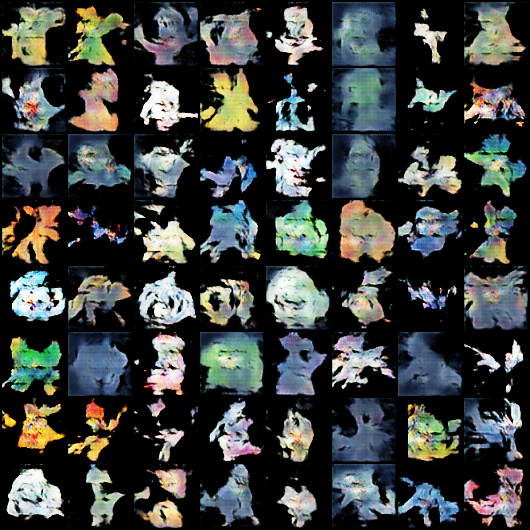

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTWO/result-image-0028.png')

### Итоговый результат 2й модели

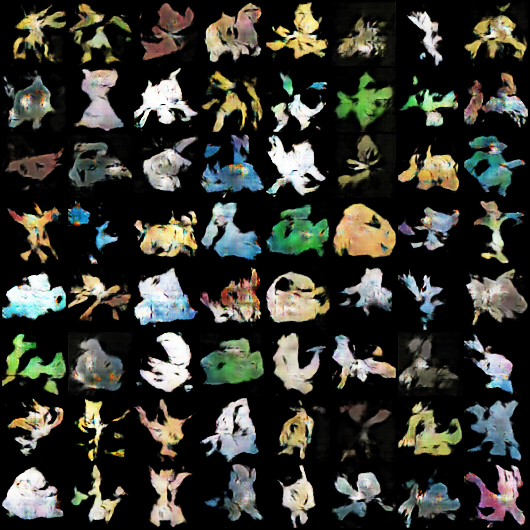

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTWO/result-image-0050.png')

### Результаты 3й модели

### Промежуточные результаты 3й модели

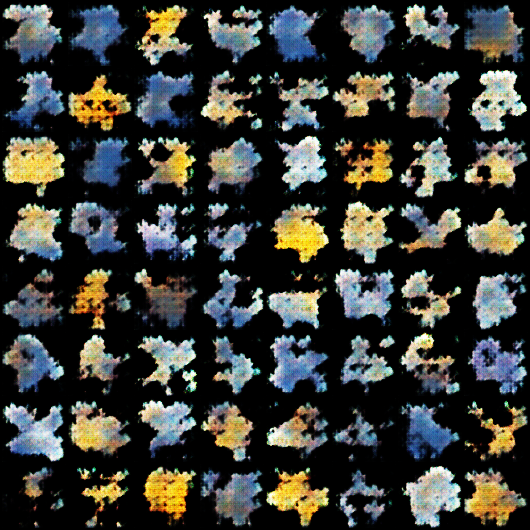

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTHREE/result-image-0006.png')

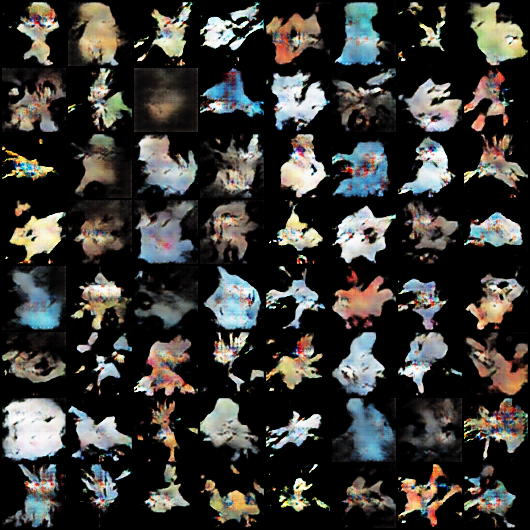

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTHREE/result-image-0025.png')

### Итоговый результат 3й модели

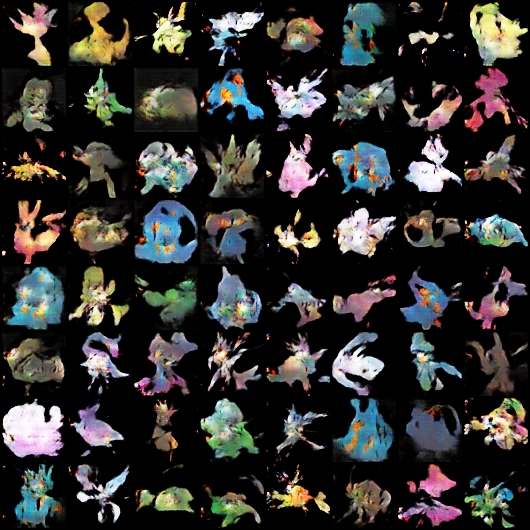

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTHREE/result-image-0048.png')

### Графики

### Графики потерь генератора и дискриминатора

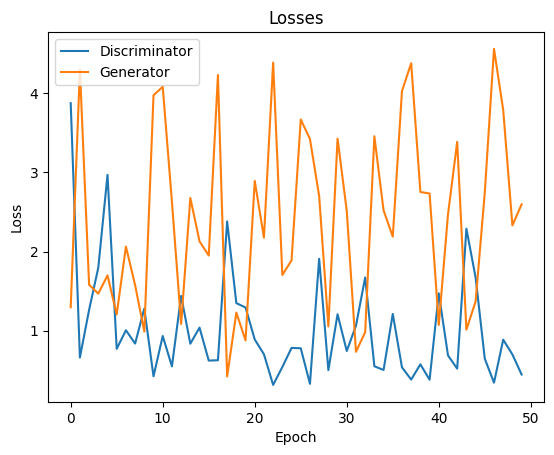

In [ ]:
# График потерь генератора и дискриминатора
plt.plot(disc_losses, '-')
plt.plot(gen_losses, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');
# Если потери генератора падают, а дискриминатора растут, это может указывать на то, что генератор успешно обманывает дискриминатор.
# Если наоборот, то дискриминатор превосходит генератор.
plt.savefig('/content/drive/MyDrive/Нейронные сети/RESULTONE/losses_plot.png')

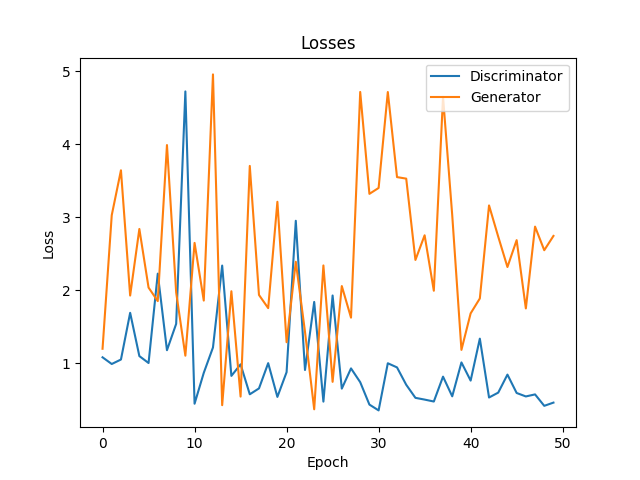

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTWO/losses_plot.png')

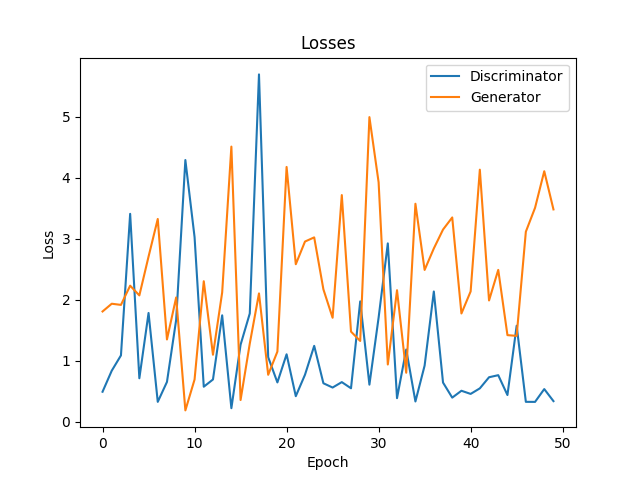

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTHREE/losses_plot.png')

### Графики оценки моделей по эпохам

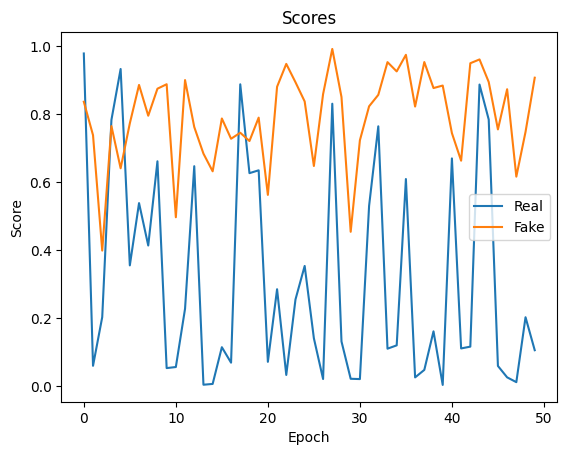

In [ ]:
# График оценки моделей по эпохам
plt.plot(disc_scores, '-')
plt.plot(gen_scores, '-')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');
# Оценки дискриминатора на настоящих и поддельных изображениях по мере обучения.
plt.savefig('/content/drive/MyDrive/Нейронные сети/RESULTONE/scores_plot.png')

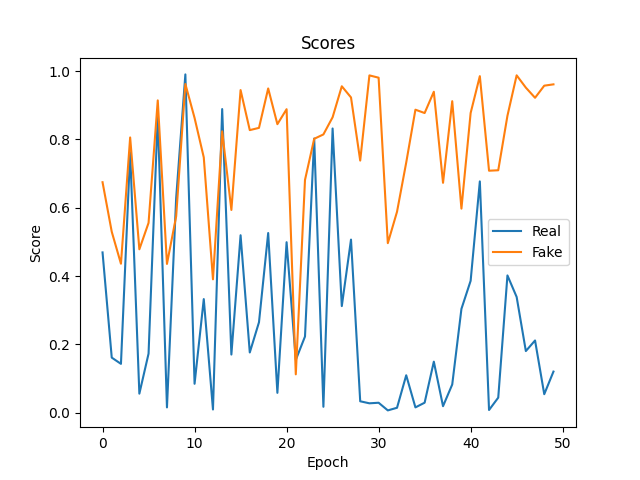

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTWO/scores_plot.png')

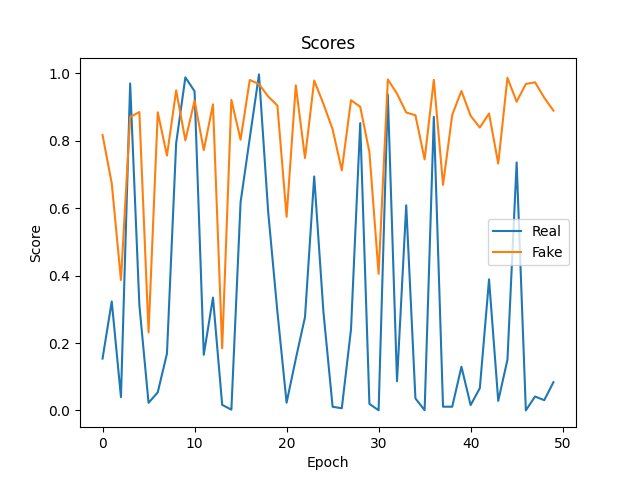

In [ ]:
Image('/content/drive/MyDrive/Нейронные сети/RESULTHREE/scores_plot.png')